In [4]:
import pandas as pd
import numpy as np
import os
import csv
import gzip
import sys
import datetime
import ast
import matplotlib.pyplot as plt
import scipy.stats as SSA
from scipy.stats import gaussian_kde

In [5]:
df_scores = pd.read_csv('../results/scores/survey_scores_perinfo.csv')

In [6]:
agency_cols = ['agency_pub_trans_avail', 'agency_pub_trans_realistic',
       'agency_uber_avail', 'agency_uber_realistic', 'agency_delivery_avail',
       'agency_delivery_realistic', 'agency_grocery_avail',
       'agency_grocery_realistic', 'agency_pharma_avail',
       'agency_pharma_realistic', 'agency_docs_avail', 'agency_docs_realistic',
       'agency_online_avail', 'agency_online_realistic',
       'agency_IP_safe_avail', 'agency_IP_safe_realistic',
       'agency_remote_avail', 'agency_remote_realistic'] +['MODZCTA','modzcta_count','regulated_agency']
df_agency = df_scores[agency_cols]

In [7]:
### there are 9 items in agencies
### not all of them are answered by all participants

In [8]:
services = ['pub_trans', 'uber', 'delivery', 'grocery', 'pharma', 'docs', 'online', 'IP_safe', 'remote']

# Loop through each service and calculate the difference between 'realistic' and 'avail'
for service in services:
    avail_col = f'agency_{service}_avail'
    realistic_col = f'agency_{service}_realistic'
    diff_col = f'agency_{service}_diff'
    
    # Calculate the difference and store in a new column
    # diff = realistic - avail (sub - obj)
    df_agency.loc[:,diff_col] = df_agency[realistic_col].copy() - df_agency[avail_col].copy()

/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_45463/3848726653.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agency.loc[:,diff_col] = df_agency[realistic_col].copy() - df_agency[avail_col].copy()
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_45463/3848726653.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agency.loc[:,diff_col] = df_agency[realistic_col].copy() - df_agency[avail_col].copy()
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_45463/384872665

In [9]:
for service in services:
    diff_col = f'agency_{service}_diff'
    group_col = f'agency_{service}_group'

    # Define the conditions for grouping
    conditions = [
        df_agency[diff_col] < 0,   # Group 1: diff < 0
        df_agency[diff_col] == 0,  # Group 2: diff == 0
        df_agency[diff_col] > 0,   # Group 3: diff > 0
        df_agency[diff_col].isna() # Group 4: NaN
    ]
    
    # Define the group numbers
    groups = [1, 2, 3, 4]
    
    # Use np.select to assign the group based on the conditions
    df_agency.loc[:, group_col] = np.select(conditions, groups, default=np.nan)

/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_45463/2155502617.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agency.loc[:, group_col] = np.select(conditions, groups, default=np.nan)
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_45463/2155502617.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agency.loc[:, group_col] = np.select(conditions, groups, default=np.nan)
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_45463/2155502617.py:17: SettingWithCopyWarn

In [10]:
diff_values_group_1 = [-1, -2, -3, -4]
diff_values_group_3 = [1, 2, 3, 4]

# Create dictionaries to store the counts for each service and each group
data_group_1 = {service: {val: 0 for val in diff_values_group_1} for service in services}
data_group_2 = {service: 0 for service in services}  # Single group for diff == 0
data_group_3 = {service: {val: 0 for val in diff_values_group_3} for service in services}

df_group_1 = df_agency[df_agency[[f'agency_{service}_group' for service in services]] == 1]

for service in services:
    diff_col = f'agency_{service}_diff'
    group_col = f'agency_{service}_group'
    
    # Group 1: diff < 0
    for val in diff_values_group_1:
        data_group_1[service][val] = df_agency.loc[df_agency[group_col] == 1, diff_col].value_counts().get(val, 0)
    
    # Group 2: diff == 0
    data_group_2[service] = df_agency.loc[df_agency[group_col] == 2, diff_col].shape[0]
    
    # Group 3: diff > 0
    for val in diff_values_group_3:
        data_group_3[service][val] = df_agency.loc[df_agency[group_col] == 3, diff_col].value_counts().get(val, 0)

In [8]:
# df_agency.to_csv('../results/scores/agency_diff.csv', index=False)

In [11]:
# Calculate total count for each service in Group 1 (red group)
total_counts = [
    sum(data_group_1[service].values()) + data_group_2[service] + sum(data_group_3[service].values())
    for service in services
]

# Calculate percentage for each service in Group 1
percentages_group_1 = {service: (sum(data_group_1[service].values()) / total) * 100 if total > 0 else 0 for service, total in zip(services, total_counts)}

# Sort services by total count in descending order
sorted_services = sorted(services, key=lambda x: percentages_group_1[x], reverse=True)
services = sorted_services
# Calculate total participants for each service across all groups
total_counts = [
    sum(data_group_1[service].values()) + data_group_2[service] + sum(data_group_3[service].values())
    for service in services
]

In [12]:
services_short_dict = {'uber':'RSA',
 'delivery':'FD',
 'online':"OS",
 'pub_trans':"PT",
 'remote':"RA",
 'IP_safe':"SIPA",
 'docs':"DH",
 'grocery':"GS",
 'pharma':"Ph"}

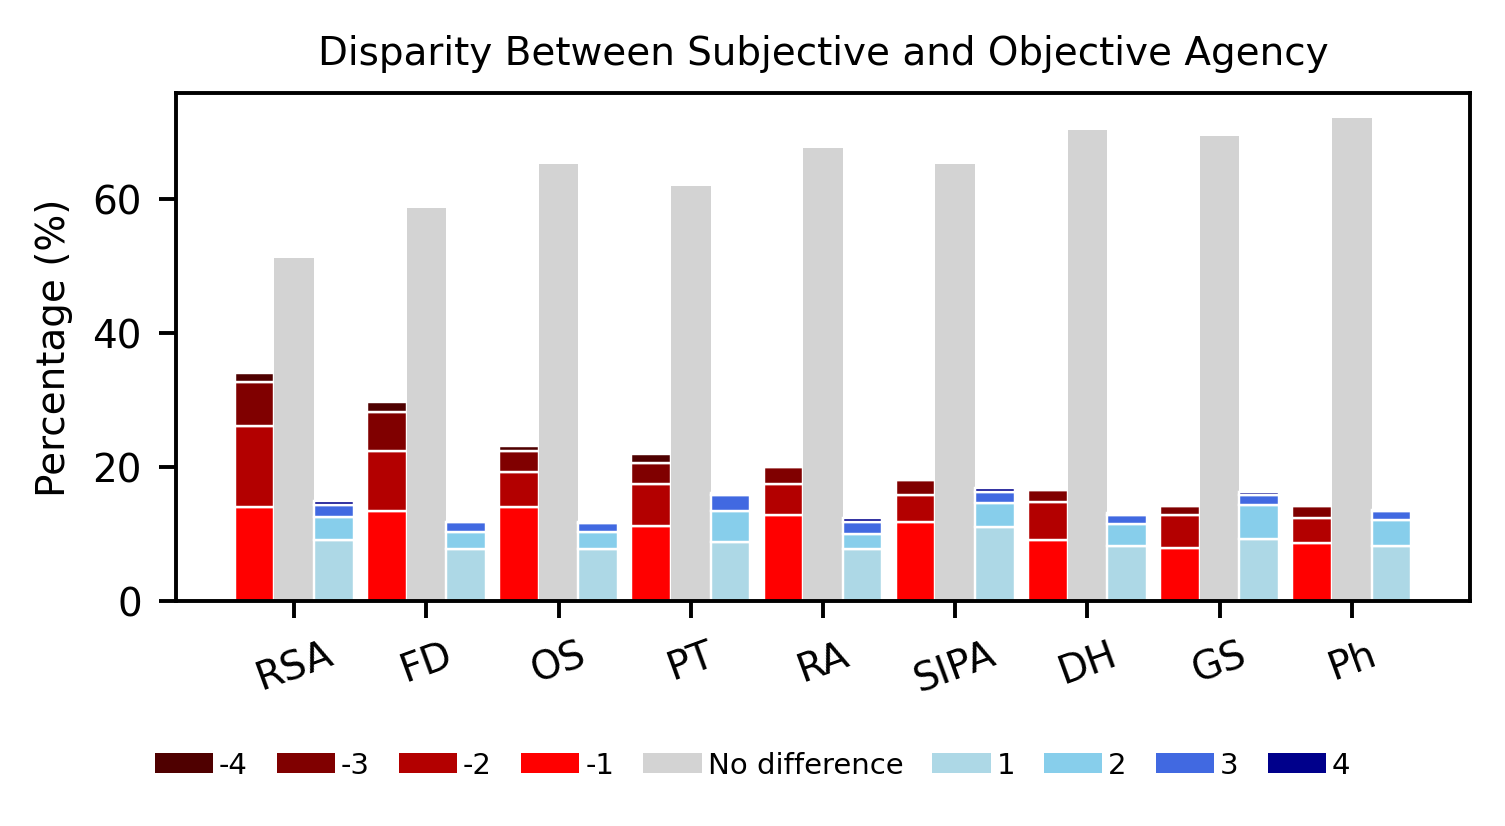

In [13]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(4.4, 2.2),dpi=350)

# Define color schemes for each group
colors_group_1 = ['#ff0000','#b30000','#800000','#4f0000']  # Darker to lighter red for Group 1
color_group_2 = '#d3d3d3'   # Single green color for Group 2
colors_group_3 = ['#ADD8E6','#87CEEB','#4169E1','#00008B']   # Darker to lighter blue for Group 3

# Define bar positions
bar_width = 0.3

indices = np.arange(len(services))

# Plot Group 1 (stacked bar)
bottom_group_1 = np.zeros(len(services))
for i, val in enumerate(sorted(diff_values_group_1,reverse=True)):
    counts_group_1 = [data_group_1[service][val] for service in services]
    percentages_group_1 = [count / total * 100 for count, total in zip(counts_group_1, total_counts)]
    ax.bar(indices - bar_width, percentages_group_1, bar_width, bottom=bottom_group_1, color=colors_group_1[i], label=f'{val}',edgecolor='white', linewidth=0.5)
    bottom_group_1 += percentages_group_1


# Plot Group 2 (single color bar)
counts_group_2 = [data_group_2[service] for service in services]
percentages_group_2 = [count / total * 100 for count, total in zip(counts_group_2, total_counts)]
ax.bar(indices, percentages_group_2, bar_width, color=color_group_2, label='No difference')


# Plot Group 3 (stacked bar)
bottom_group_3 = np.zeros(len(services))

for i, val in enumerate(diff_values_group_3):
    counts_group_3 = [data_group_3[service][val] for service in services]
    percentages_group_3 = [count / total * 100 for count, total in zip(counts_group_3, total_counts)]
    ax.bar(indices + bar_width, percentages_group_3, bar_width, bottom=bottom_group_3, color=colors_group_3[i], label=f'{val}',edgecolor='white', linewidth=0.5)
    bottom_group_3 += percentages_group_3


# Add labels, title, and legend
ax.set_ylabel('Percentage (%)', fontsize=8)
ax.set_title('Disparity Between Subjective and Objective Agency', size=8)
ax.set_xticks(indices)
ax.tick_params(axis='both', labelsize=8)
# services_name = ['ride share' if x == 'uber' else x for x in services]
services_name = services_short_dict.values()
ax.set_xticklabels(services_name, fontsize=8, rotation=20)

legend_labels = [-4, -3, -2, -1, 'No difference', 1, 2, 3, 4]
legend_colors = ['#4f0000', '#800000', '#b30000', '#ff0000', '#d3d3d3', '#ADD8E6', '#87CEEB', '#4169E1', '#00008B']

# Create custom legend handles in the specified order
legend_patches = [
    mpatches.Patch(color=color, label=str(label), linewidth=0)
    for label, color in zip(legend_labels, legend_colors)
]
# Add the custom legend to the figure
fig.legend(handles=legend_patches, bbox_to_anchor=(0.5, -0.07),loc='lower center', ncol=9, frameon=False, fontsize=6, handletextpad=0.2, labelspacing=0, columnspacing=1)


plt.tight_layout()
# plt.savefig('../results/scores/agency_diff_hist.png', bbox_inches='tight',pad_inches=0.1,dpi=350,transparent=True)

0 uber
1 delivery
2 online
3 pub_trans
4 remote
5 IP_safe
6 docs
7 grocery
8 pharma


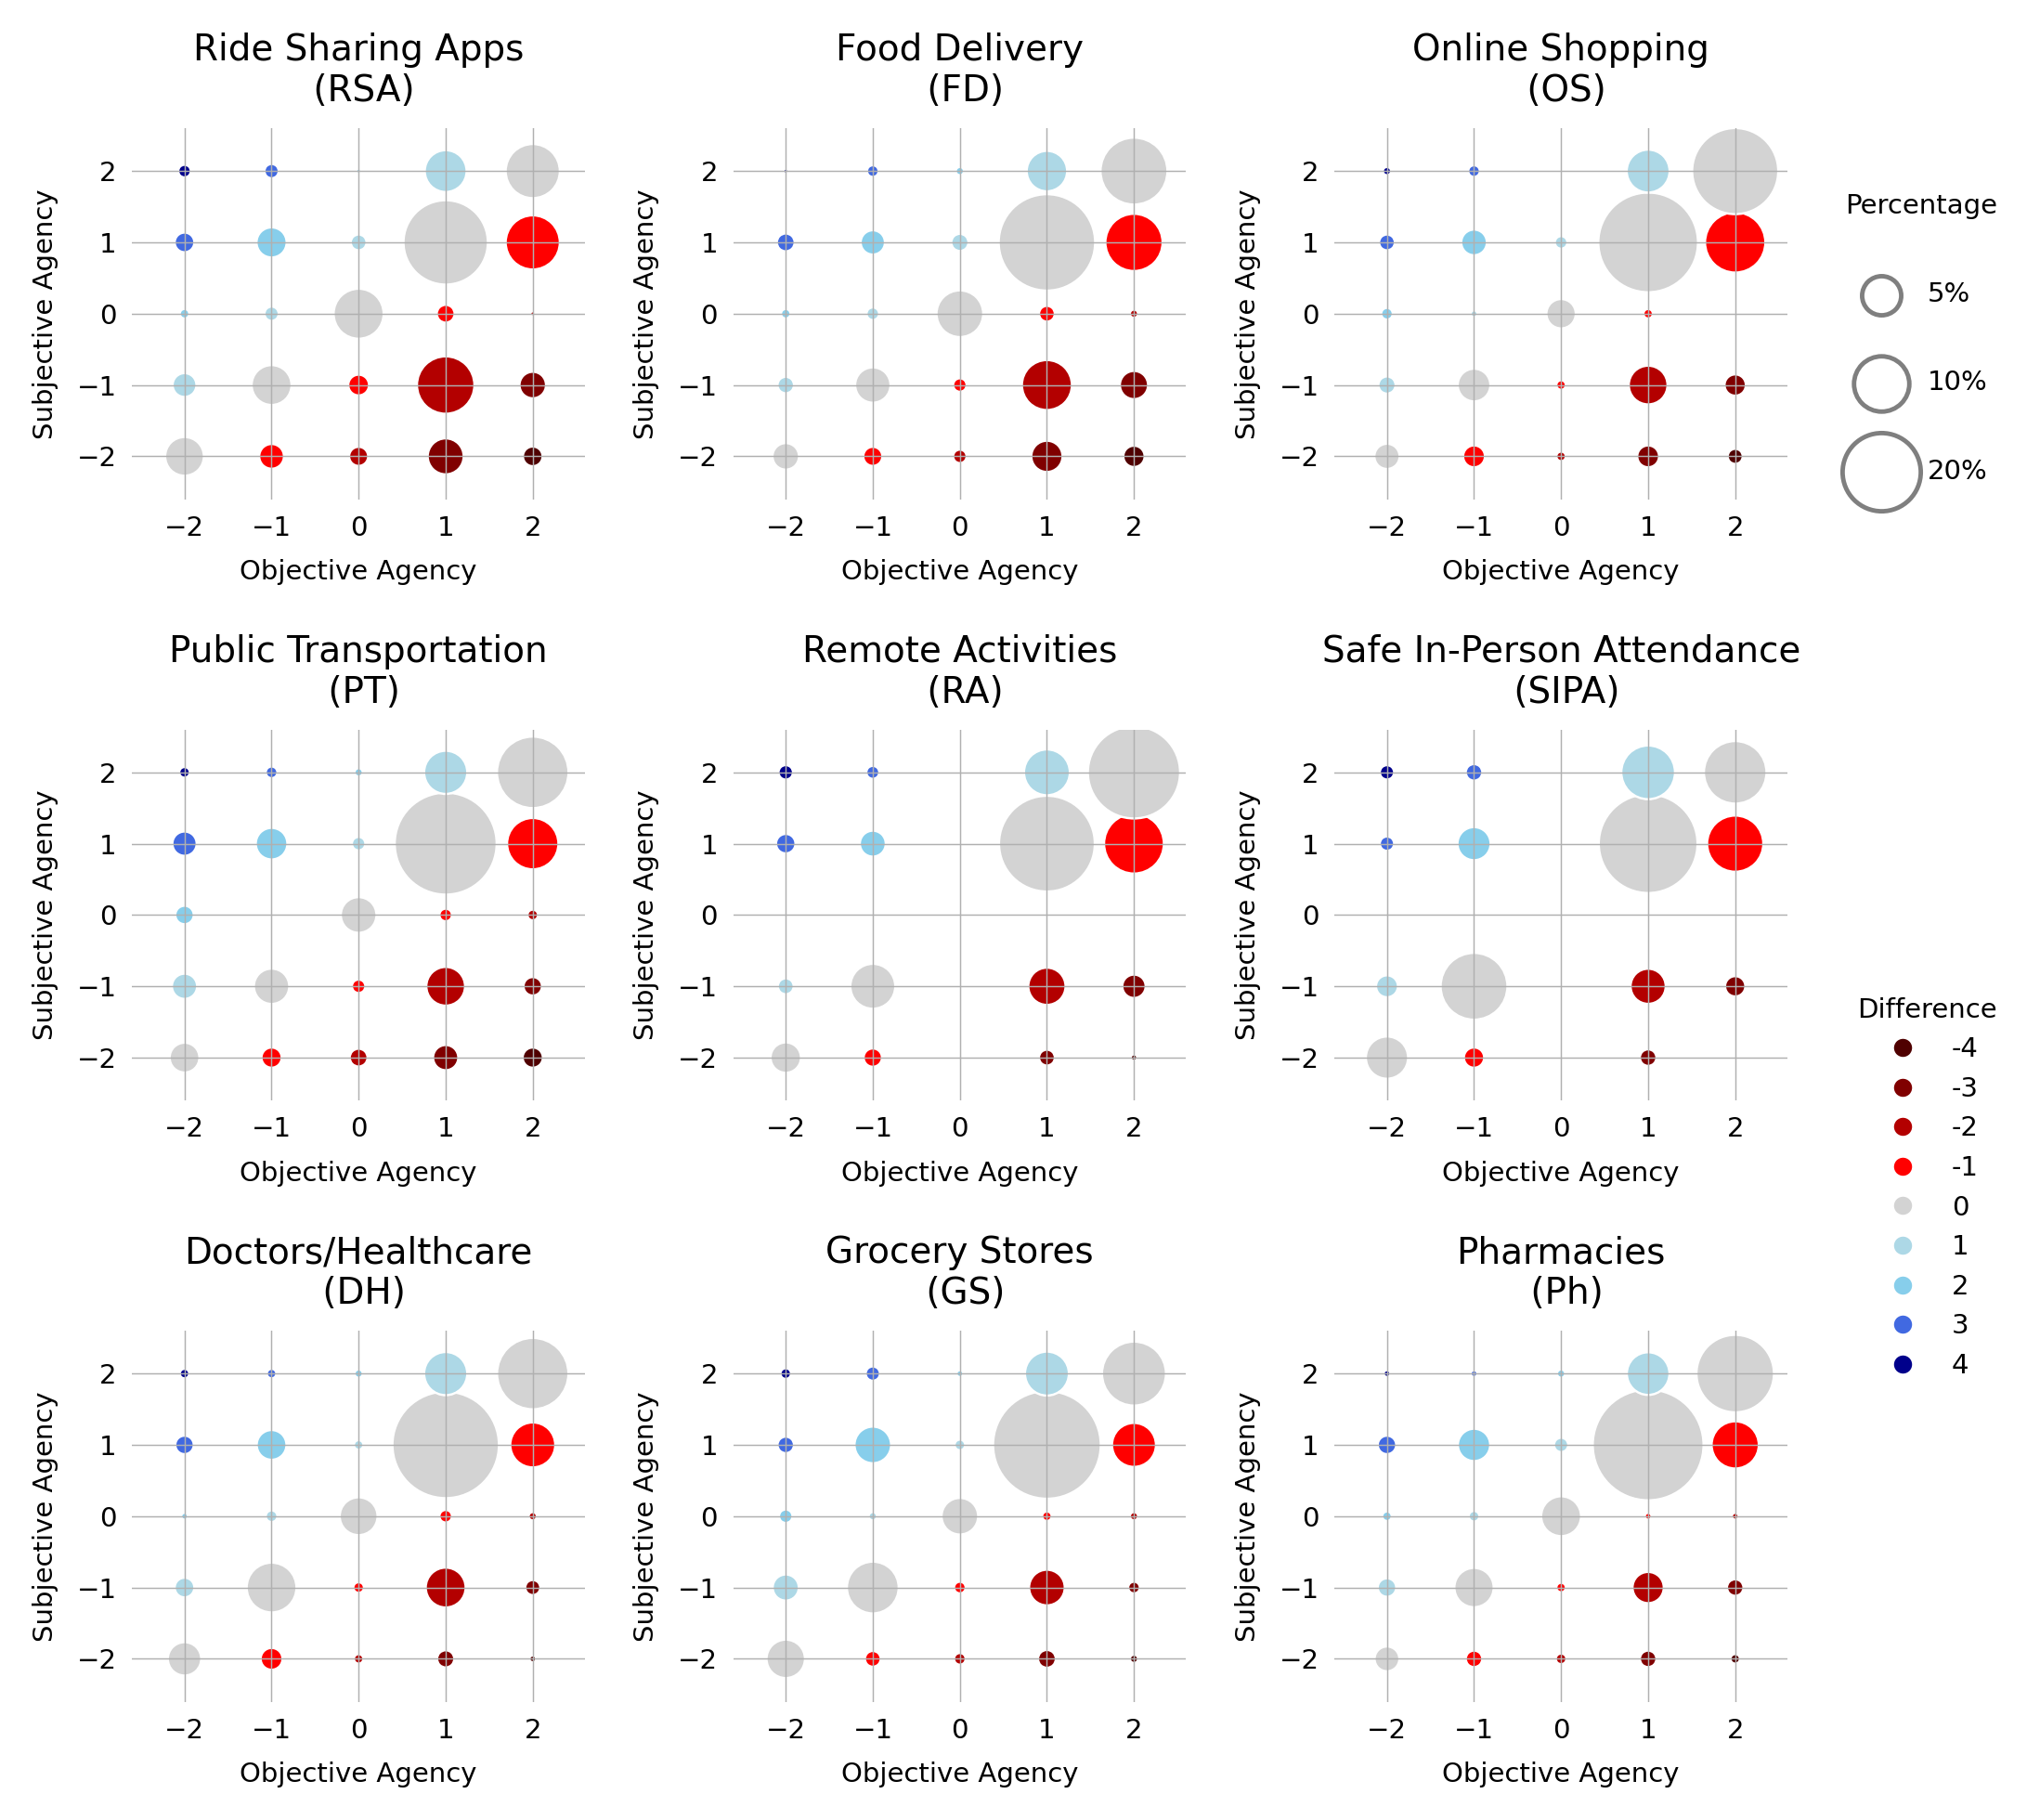

In [14]:
color_map = {-4:'#4f0000', -3:'#800000', -2:'#b30000', -1:'#ff0000', 0:'#d3d3d3',1:'#ADD8E6', 2:'#87CEEB', 3:'#4169E1', 4:'#00008B'}
service_title_dic = {'pub_trans':'Public Transportation, (PT)', 'uber':'Ride Sharing Apps, (RSA)', 'delivery':'Food Delivery, (FD)', 'grocery':'Grocery Stores, (GS)', 'pharma':'Pharmacies, (Ph)', 'docs':'Doctors/Healthcare, (DH)', 'online':'Online Shopping, (OS)', 'IP_safe': 'Safe In-Person Attendance, (SIPA)', 'remote': 'Remote Activities, (RA)'}
# Set up the 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(5.7, 5.7), dpi=350)
axes = axes.flatten()  # Flatten to easily index for each service

for idx, service in enumerate(services):
    print(idx,service)
    ax = axes[idx]
    x_col = f'agency_{service}_avail'
    y_col = f'agency_{service}_realistic'
    

    grouped = df_agency.groupby([x_col, y_col]).size().reset_index(name='count')
    total_count = grouped['count'].sum()
    counts = grouped['count'].values
    grouped['percentage'] = grouped['count'] / total_count * 100  

    x = grouped[x_col].values
    y = grouped[y_col].values
    differences = y - x
    percentages = grouped['percentage'].values

 # Plot each point
    scatter = ax.scatter(x,  y, s=percentages * 15,  c=[color_map[diff] for diff in differences],  # Color based on difference
        edgecolor='w', linewidth=0.5
    )
    # scatter = ax.scatter(x,  y, s=counts * 1.2,  c=[color_map[diff] for diff in differences],  # Color based on difference
        # edgecolor='w', linewidth=0.5)

    # Set title and labels
    # ax.set_title(f'{service_title_dic[service]}',fontsize=8)
    title_text = service_title_dic[service].replace(',', '\n')
    ax.set_title(title_text, fontsize=8)
    ax.set_xlabel('Objective Agency', fontsize=6)
    ax.set_ylabel('Subjective Agency', fontsize=6)

    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_xlim(-2.6, 2.6)
    ax.set_ylim(-2.6, 2.6)
    ax.tick_params(axis='both', which='both', length=0, labelsize=6)

    ax.grid(True,linewidth=0.3)
    for spine in ax.spines.values():
        spine.set_visible(False)


# Add a color legend
# Use a proxy artist for legend entries, with labels and colors
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=5, label=lab)
                  for lab, col in color_map.items()]

fig.legend(handles=legend_patches, loc='right', title="Difference",bbox_to_anchor=(1.1, 0.35), frameon=False,fontsize=6,title_fontsize=6)

# for size in [50, 100, 200, 300]: 
for size in [5, 10, 20]: # Example sizes; adjust as needed
    plt.scatter([], [], s=size*15, c="white", alpha=0.5, edgecolors="black", label=str(size)+'%')
fig.legend(title='Percentage', loc='upper right', bbox_to_anchor=(1.1, 0.9), frameon=False, fontsize=6, handletextpad=0.7, labelspacing=2.3,title_fontsize=6)

plt.tight_layout()
# plt.show()
# plt.savefig('../results/scores/avail_vs_real.png', bbox_inches='tight',pad_inches=0.1,dpi=350,transparent=True,)

## Geography 
I only use the 7 terms (14) questions here to plot!!!

In [15]:
# score_path = '../results/scores/'
# df_agency = pd.read_csv(score_path+'agency_scores.csv')
services_to_plot = ['uber',
 'delivery',
 'online',
 'pub_trans',
 'docs',
 'grocery',
 'pharma']

df_agency = df_agency.copy()

avail_sum = df_agency[['agency_'+s+'_avail' for s in services_to_plot]].sum(axis=1,skipna=True)
realistic_sum = df_agency[['agency_'+s+'_realistic' for s in services_to_plot]].sum(axis=1,skipna=True)

# # Adding the sums as new columns to the dataframe
df_agency['total_avail'] = avail_sum
df_agency['total_realistic'] = realistic_sum
df_agency['num_items'] = df_agency.apply(lambda row: row[1:19].notna().sum(), axis=1)

# print('item=14', sum(df_agency['num_items'] == 14))
# print('item=16', sum(df_agency['num_items'] == 16))
# print('item=18', sum(df_agency['num_items'] == 18))
# #### most of them answered 16 items and then we used 16 items for rescaling
# df_agency['rescale_avail'] = df_agency['total_avail'] / (df_agency['num_items'] / 2) * 8
# df_agency['rescale_realistic'] = df_agency['total_realistic'] / (df_agency['num_items'] / 2) * 8
# df_agency['agency'] = df_agency['rescale_avail'] + df_agency['rescale_realistic']
# df_agency['agency_diff'] = df_agency['rescale_realistic'] - df_agency['rescale_avail'] 

df_agency['agency'] = df_agency['total_avail'] + df_agency['total_realistic']
df_agency['agency_diff'] = df_agency['total_realistic'] - df_agency['total_avail'] 

In [17]:
df_agency[df_agency['modzcta_count'] >= 15]['num_items'].value_counts()

num_items
16    563
14    327
18    159
Name: count, dtype: int64

In [15]:
df_agency.columns

Index(['agency_pub_trans_avail', 'agency_pub_trans_realistic',
       'agency_uber_avail', 'agency_uber_realistic', 'agency_delivery_avail',
       'agency_delivery_realistic', 'agency_grocery_avail',
       'agency_grocery_realistic', 'agency_pharma_avail',
       'agency_pharma_realistic', 'agency_docs_avail', 'agency_docs_realistic',
       'agency_online_avail', 'agency_online_realistic',
       'agency_IP_safe_avail', 'agency_IP_safe_realistic',
       'agency_remote_avail', 'agency_remote_realistic', 'MODZCTA',
       'modzcta_count', 'regulated_agency', 'agency_pub_trans_diff',
       'agency_uber_diff', 'agency_delivery_diff', 'agency_grocery_diff',
       'agency_pharma_diff', 'agency_docs_diff', 'agency_online_diff',
       'agency_IP_safe_diff', 'agency_remote_diff', 'agency_pub_trans_group',
       'agency_uber_group', 'agency_delivery_group', 'agency_grocery_group',
       'agency_pharma_group', 'agency_docs_group', 'agency_online_group',
       'agency_IP_safe_group', 'ag

In [18]:
def compute_mode(values):
    if len(values) == 1:  # If only one value, return it as the mode
        return values.iloc[0]
    kde = gaussian_kde(values)
    x_vals = np.linspace(min(values), max(values), 100)
    kde_vals = kde(x_vals)
    mode = x_vals[np.argmax(kde_vals)]
    return mode

# Group by MODZCTA and calculate the mode for each score
df_s = df_agency[df_agency['modzcta_count'] >= 15][['total_avail', 'total_realistic', 'MODZCTA']]
# df_mode = df_s.groupby('MODZCTA').apply(lambda x: pd.Series({
#     'avail_mode': compute_mode(x['total_avail']),
#     'realistic_mode': compute_mode(x['total_realistic'])  # Calculate mode for 'agency_diff' as well
# })).reset_index()

df_m = df_s.groupby('MODZCTA').apply(lambda x: pd.Series({
    'avail_mean': x['total_avail'].mean(),
    'realistic_mean': x['total_realistic'].mean()  # Calculate mean for 'agency_diff' as well, if applicable
    ,'avail_mode': compute_mode(x['total_avail']),
    'realistic_mode': compute_mode(x['total_realistic'])  # Calculate mode for 'agency_diff' as well
    })).reset_index()

/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_45463/2289674602.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_m = df_s.groupby('MODZCTA').apply(lambda x: pd.Series({


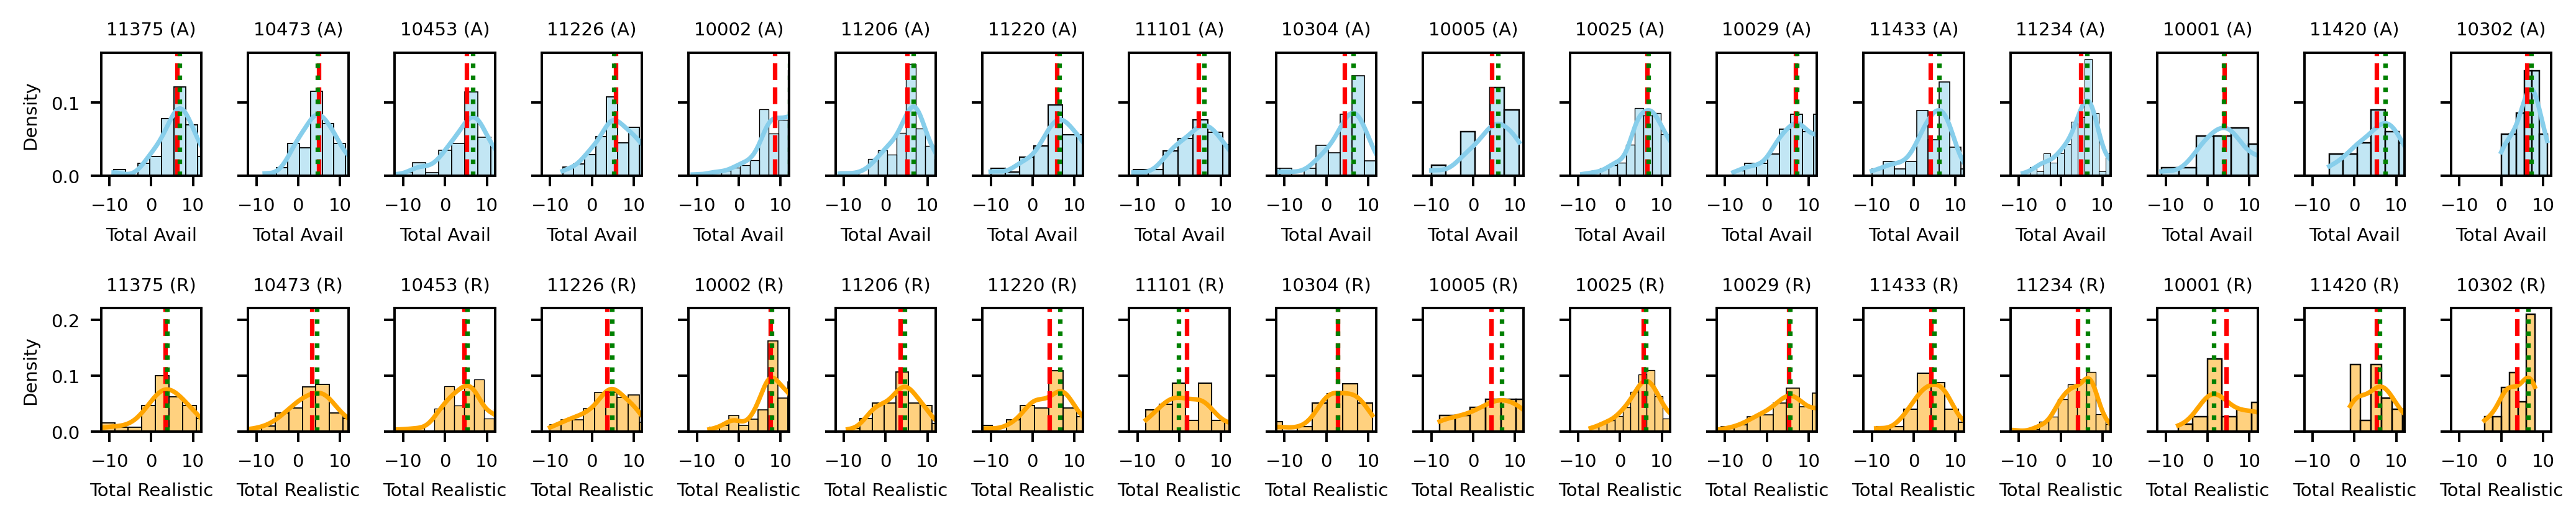

In [34]:
import seaborn as sns
modzcta_groups = df_s['MODZCTA'].unique()
fig, axes = plt.subplots(2, len(modzcta_groups), figsize=(12, 2.5), sharey='row', dpi=350)

# Plot histogram and density with mean/mode indicators for each MODZCTA
for idx, modzcta in enumerate(modzcta_groups):
    # Filter data for the current MODZCTA
    group_data = df_s[df_s['MODZCTA'] == modzcta]
    
    # Plot for 'total_avail'
    sns.histplot(group_data['total_avail'], kde=True, ax=axes[0, idx], stat="density", color="skyblue")
    axes[0, idx].set_xlabel('Total Avail', fontsize=6)
    axes[0, idx].set_ylabel('Density', fontsize=6)
    axes[0, idx].tick_params(axis='x', labelsize=6)
    axes[0, idx].tick_params(axis='y', labelsize=6)
    mean_avail = group_data['total_avail'].mean()
    mode_avail = compute_mode(group_data['total_avail'])
    axes[0, idx].axvline(mean_avail, color='red', linestyle='--', label=f"Mean: {mean_avail:.2f}")
    axes[0, idx].axvline(mode_avail, color='green', linestyle=':', label=f"Mode: {mode_avail:.2f}")
    axes[0, idx].set_title(f'{modzcta} (A)',size=6)
    axes[0, idx].set_xlim(-12, 12)
    # axes[0, idx].legend()

    # Plot for 'total_realistic'
    sns.histplot(group_data['total_realistic'], kde=True, ax=axes[1, idx], stat="density", color="orange")
    axes[1, idx].set_xlabel('Total Realistic', fontsize=6)
    axes[1, idx].set_ylabel('Density', fontsize=6)
    axes[1, idx].tick_params(axis='x', labelsize=6)
    axes[1, idx].tick_params(axis='y', labelsize=6)
    mean_realistic = group_data['total_realistic'].mean()
    mode_realistic = compute_mode(group_data['total_realistic'])
    axes[1, idx].axvline(mean_realistic, color='red', linestyle='--', label=f"Mean: {mean_realistic:.2f}")
    axes[1, idx].axvline(mode_realistic, color='green', linestyle=':', label=f"Mode: {mode_realistic:.2f}")
    axes[1, idx].set_title(f'{modzcta} (R)',size=6)
    axes[1, idx].set_xlim(-12, 12)
    # axes[1, idx].legend()

# Adjust layout
plt.tight_layout()
# plt.show()
# plt.savefig('../results/scores/modzcta_avail_realistic_hist.png', bbox_inches='tight',pad_inches=0.1,dpi=350,transparent=True)

In [20]:
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

gdf = gpd.read_file('../Data/geography_data/MODZCTA_2010.shp')
gdf['MODZCTA'] = gdf['MODZCTA'].astype(np.int64)
# gdf_merged = gdf.merge(df_mode, on='MODZCTA', how='right')
gdf_merged = gdf.merge(df_m, on='MODZCTA', how='right')

In [21]:
used_mod = df_scores[df_scores['modzcta_count'] >=15]['MODZCTA'].unique()
highlight_indices = gdf_merged.index[gdf_merged['MODZCTA'].isin(used_mod)].tolist()
highlight_gdf = gdf_merged.iloc[highlight_indices]

In [22]:
(gdf_merged['avail_mode'].max(), gdf_merged['avail_mode'].min()), (gdf_merged['realistic_mode'].max(), gdf_merged['realistic_mode'].min())
# (gdf_merged['avail_mean'].max(), gdf_merged['avail_mean'].min()), (gdf_merged['realistic_mean'].max(), gdf_merged['realistic_mean'].min())


((12.232323232323235, 3.8989898989898997),
 (7.8484848484848495, -0.22222222222222232))

<Axes: >

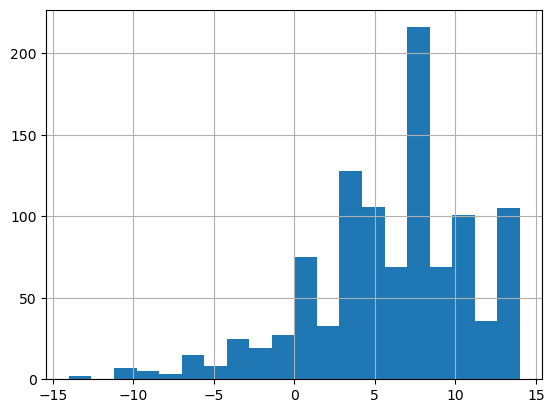

In [35]:
df_s['total_avail'].hist(bins=20)

<Axes: >

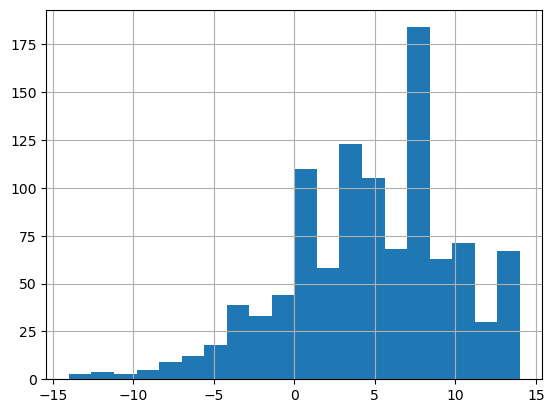

In [36]:
df_s['total_realistic'].hist(bins=20)

In [37]:
from PIL import ImageColor
# Normalize the color ranges
import matplotlib.colors as mcolors
num_bins = 3  # Adjust based on data distribution
bin_edges_r_y = np.linspace(-1, 8, num_bins + 1)
bin_edges_a_x = np.linspace(3.5, 12.5, num_bins + 1)

# Assign values to bins
gdf_merged['avail_mode_bin'] = pd.cut(
    gdf_merged['avail_mode'], bins=bin_edges_a_x, labels=False, include_lowest=True
)

gdf_merged['realistic_mode_bin'] = pd.cut(
    gdf_merged['realistic_mode'], bins=bin_edges_r_y, labels=False, include_lowest=True
)

# gdf_merged['avail_mode_bin'], bin_edges_a = pd.qcut(
#     gdf_merged['avail_mode'], q=num_bins, labels=False,retbins=True)

# gdf_merged['realistic_mode_bin'], bin_edges_r = pd.qcut(
#     gdf_merged['realistic_mode'], q=num_bins, labels=False, retbins=True)

gdf_merged['color'] = [ v1 * num_bins + v2 for v1, v2 in zip(gdf_merged['realistic_mode_bin'], gdf_merged['avail_mode_bin'])]

In [41]:
bin_edges_r_y

array([-1.,  2.,  5.,  8.])

In [38]:
gdf_merged

,MODZCTA,label,geometry,avail_mean,realistic_mean,avail_mode,realistic_mode,avail_mode_bin,realistic_mode_bin,color
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",4.090909,4.454545,3.898990,1.484848,0,0,0
1,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19...",8.628099,7.504132,12.232323,7.848485,2,2,8
2,10005,10005,"POLYGON ((982126.000 195468.000, 982080.000 19...",4.526316,4.263158,5.909091,6.888889,0,2,6
3,10025,10025,"POLYGON ((993512.000 226772.000, 993386.000 22...",6.544776,5.611940,6.797980,6.151515,1,2,7
4,10029,10029,"POLYGON ((997976.000 225838.000, 997840.000 22...",6.814815,5.240741,7.111111,5.515152,1,2,7
5,10302,10302,"POLYGON ((943786.000 169178.000, 943788.000 16...",6.157895,3.789474,7.111111,6.424242,1,2,7
6,10304,10304,"POLYGON ((959984.000 156534.000, 960080.000 15...",4.393939,2.727273,6.484848,2.666667,0,1,3
7,10453,10453,"POLYGON ((1006610.000 247544.000, 1006462.000 ...",5.123288,4.534247,6.646465,5.333333,1,2,7
8,10473,10473,"POLYGON ((1026944.000 234996.000, 1026920.000 ...",4.954545,3.318182,4.666667,4.545455,0,1,3
9,11101,11101,"POLYGON ((995974.000 208670.000, 995948.000 20...",4.545455,1.727273,5.919192,-0.222222,0,0,0


In [65]:
# colorname_list = ['#E9E8E8','#E3D8AC','#C9B459','#CCB8D6','#C9ADA0','#AF8D53','#9973AF','#976B82','#814D37']
colorname_dict = {0:'#a31818',1:'#3d0101',2:'#0F0000',3:'#ee7272',4:'#a31818',5:'#3d0101',6:'#99D2E4',7:'#ee7272',8:'#a31818'}
colorname_list = [colorname_dict[i] for i in range(9)]
hatches = ['//////', '//////', ' ', '\\\\\\', '....', '\\\\\\', ' ', '\\\\\\', '\\\\\\']

def hex_to_rgb_normalized(hexcode):
    """
    Convert a hex color code to an RGB tuple with normalized values (0 to 1).
    """
    rgb = ImageColor.getcolor(hexcode, 'RGB')  # Convert hex to RGB tuple
    return np.array(tuple(v / 255 for v in rgb))

colorlist = [hex_to_rgb_normalized(color) for color in colorname_list]
bivariate_cmap = mcolors.ListedColormap(colorlist)

/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_45463/411421796.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  rect = Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch)


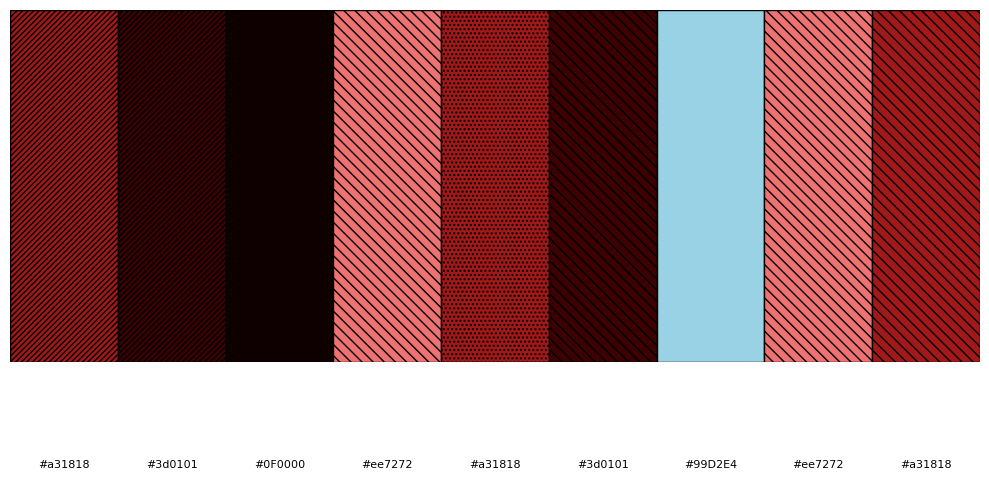

In [66]:
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(10, 5))

# Add patches directly to the plot
n_colors = len(colorname_list)
for i, (color, hatch) in enumerate(zip(colorlist, hatches)):
    rect = Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch)
    ax.add_patch(rect)
    ax.text(i + 0.5, -0.3, f'{colorname_list[i]}', ha='center', fontsize=8)

# Set limits and hide axes
ax.set_xlim(0, n_colors)
ax.set_ylim(0, 1)
ax.axis('off')  # Turn off the axes for cleaner display

# Show the plot
plt.tight_layout()
plt.show()

<Axes: >

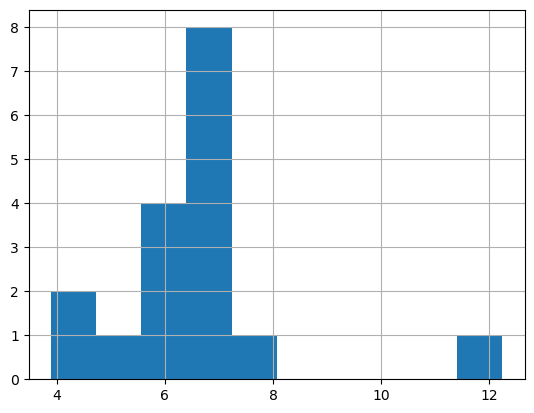

In [67]:
gdf_merged['avail_mode'].hist(bins=10)

<Axes: >

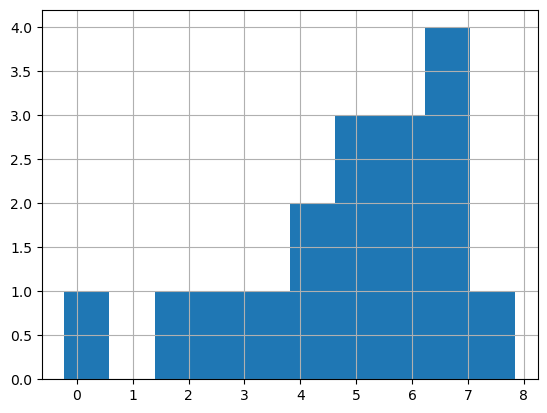

In [68]:
gdf_merged['realistic_mode'].hist(bins=10)

In [69]:
hatches = ['//////', '//////', None, '//////', None, '.....', None, '.....', '.....']

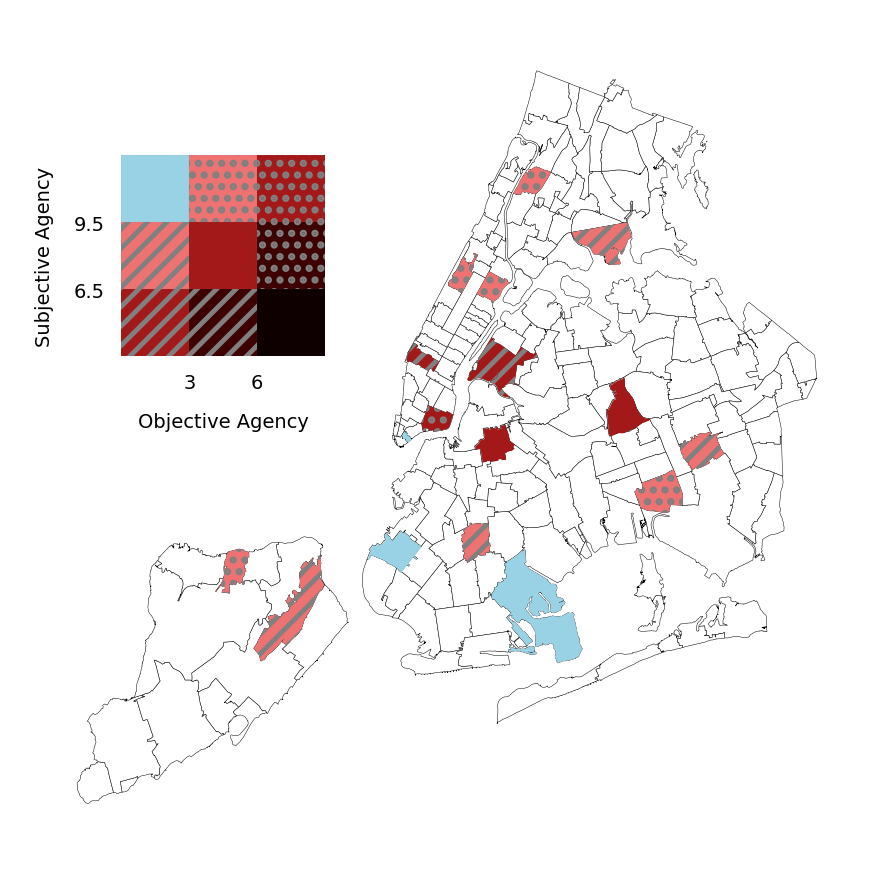

In [71]:
# Plot the map with the bivariate color scheme
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from shapely.geometry import Polygon, MultiPolygon

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=350)
gdf.plot(ax=ax, color='white', alpha=1, edgecolor='black', linewidth=.1)

# gdf_merged['plot_color'] = gdf_merged['color'].apply(lambda x: tuple(colorlist[x]))
# gdf_merged.plot(color=gdf_merged['plot_color'],
#     linewidth=0.1,
#     edgecolor='black',
#     legend=False,
#     ax=ax
# )

for idx, row in gdf_merged.iterrows():
    
    color = tuple(colorlist[row['color']])
    hatch = hatches[row['color']] 
    # print(row['color'], hatch)
  
    gdf_merged.loc[[idx]].plot(
        ax=ax,
        color=color,
        linewidth=0.0001,
        edgecolor='grey',
        alpha=1,
        hatch= hatch
    )

# ax.autoscale_view()
# for x, y, label in zip(gdf_merged.geometry.centroid.x, 
#                        gdf_merged.geometry.centroid.y, 
#                        gdf_merged['MODZCTA']):
#     ax.annotate(label, xy=(x, y), xytext=(3, 3),
#                 textcoords="offset points", fontsize=4, color="black")


ax.axis("off")

# Create an inset axes for the color legend at the bottom right
legend_ax = ax.inset_axes([0.1, 0.6, 0.25, 0.25]) #inset_axes(ax, width="20%", height="20%", loc='upper left', borderpad=2)

# legend_ax.set_aspect('equal', adjustable='box')
# for i in range(num_bins):
#     for j in range(num_bins):
#         legend_ax.add_patch(plt.Rectangle((j, i), 1, 1, color=colorlist[i * num_bins + j]))

# num_bins = 3  # Replace with your bin count
for i in range(num_bins):
    for j in range(num_bins):
        color = colorlist[i * num_bins + j]
        hatch = hatches[i * num_bins + j] if i * num_bins + j < len(hatches) else None
        rect = Rectangle((j, i), 1, 1, facecolor=color, edgecolor='grey', hatch=hatch,linewidth=0.01)
        legend_ax.add_patch(rect)

legend_ax.set_xlim([0, num_bins])
legend_ax.set_ylim([0, num_bins])
# legend_ax.set_xticks(range(num_bins))
# legend_ax.set_yticks(range(num_bins))


# # Configure the colorbar with tick labels
legend_ax.set_xticks([1.,2.])
legend_ax.set_yticks([1.,2.])
legend_ax.set_xticklabels(['3', '6'])  # Customize labels based on your data
legend_ax.set_yticklabels(['6.5', '9.5'])

for label in legend_ax.get_xticklabels():
    label.set_fontsize(4)  # Adjust fontsize here

for label in legend_ax.get_yticklabels():
    label.set_fontsize(4)  # Adjust fontsize here

legend_ax.set_xlabel("Objective Agency", fontsize=4)
legend_ax.set_ylabel("Subjective Agency", fontsize=4)

# # Remove the frame of the legend
legend_ax.spines['top'].set_visible(False)
legend_ax.spines['right'].set_visible(False)
legend_ax.spines['bottom'].set_visible(False)
legend_ax.spines['left'].set_visible(False)
legend_ax.tick_params(axis='both', which='both', length=0)

# # Optionally, adjust label font size
# for label in legend_ax.get_xticklabels() + legend_ax.get_yticklabels():
#     label.set_fontsize(8)

# Set title
# plt.show()
plt.savefig('../results/scores/bivariate_map.png', bbox_inches='tight',pad_inches=0.1,dpi=350,transparent=True)

In [ ]:
df_s2 = df_agency[df_agency['modzcta_count'] >= 15][agency_cols]
df_grouped_services = df_s2.groupby('MODZCTA').mean().reset_index()

In [32]:
gdf_merged_services

,MODZCTA,label,geometry,agency_pub_trans_avail,agency_pub_trans_realistic,agency_uber_avail,agency_uber_realistic,agency_delivery_avail,agency_delivery_realistic,agency_grocery_avail,...,IP_safe_bivariate_class,docs_avail_bin,docs_realistic_bin,docs_bivariate_class,grocery_avail_bin,grocery_realistic_bin,grocery_bivariate_class,pharma_avail_bin,pharma_realistic_bin,pharma_bivariate_class
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",0.136364,0.227273,0.363636,0.045455,0.681818,0.863636,0.681818,...,8,2,2,8,2,1,5,0,0,0
1,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19...",1.206612,1.049587,1.297521,1.165289,1.206612,1.082645,1.033058,...,8,2,2,8,2,2,8,2,2,8
2,10005,10005,"POLYGON ((982126.000 195468.000, 982080.000 19...",0.421053,0.526316,0.631579,0.684211,0.789474,0.368421,0.368421,...,3,0,1,3,0,2,6,1,0,1
3,10025,10025,"POLYGON ((993512.000 226772.000, 993386.000 22...",0.947761,0.723881,0.641791,0.343284,0.873134,0.574627,0.932836,...,8,2,2,8,2,2,8,2,2,8
4,10029,10029,"POLYGON ((997976.000 225838.000, 997840.000 22...",1.074074,0.787037,0.740741,0.203704,1.064815,0.768519,0.805556,...,5,2,2,8,2,2,8,2,2,8
5,10302,10302,"POLYGON ((943786.000 169178.000, 943788.000 16...",0.789474,0.368421,0.578947,-0.473684,1.210526,0.210526,0.631579,...,1,1,0,1,2,2,8,2,2,8
6,10304,10304,"POLYGON ((959984.000 156534.000, 960080.000 15...",0.515152,0.696970,0.333333,-0.151515,0.757576,0.151515,0.181818,...,4,1,0,1,0,0,0,1,0,1
7,10453,10453,"POLYGON ((1006610.000 247544.000, 1006462.000 ...",0.780822,0.863014,0.465753,0.082192,0.890411,0.506849,0.547945,...,7,1,2,7,1,1,4,2,1,5
8,10473,10473,"POLYGON ((1026944.000 234996.000, 1026920.000 ...",0.606061,0.454545,0.318182,-0.196970,0.909091,0.424242,0.409091,...,4,2,1,5,0,0,0,0,0,0
9,11101,11101,"POLYGON ((995974.000 208670.000, 995948.000 20...",0.787879,0.545455,0.696970,-0.363636,0.939394,0.090909,0.090909,...,0,0,0,0,0,0,0,0,0,0


/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_69737/4054051239.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


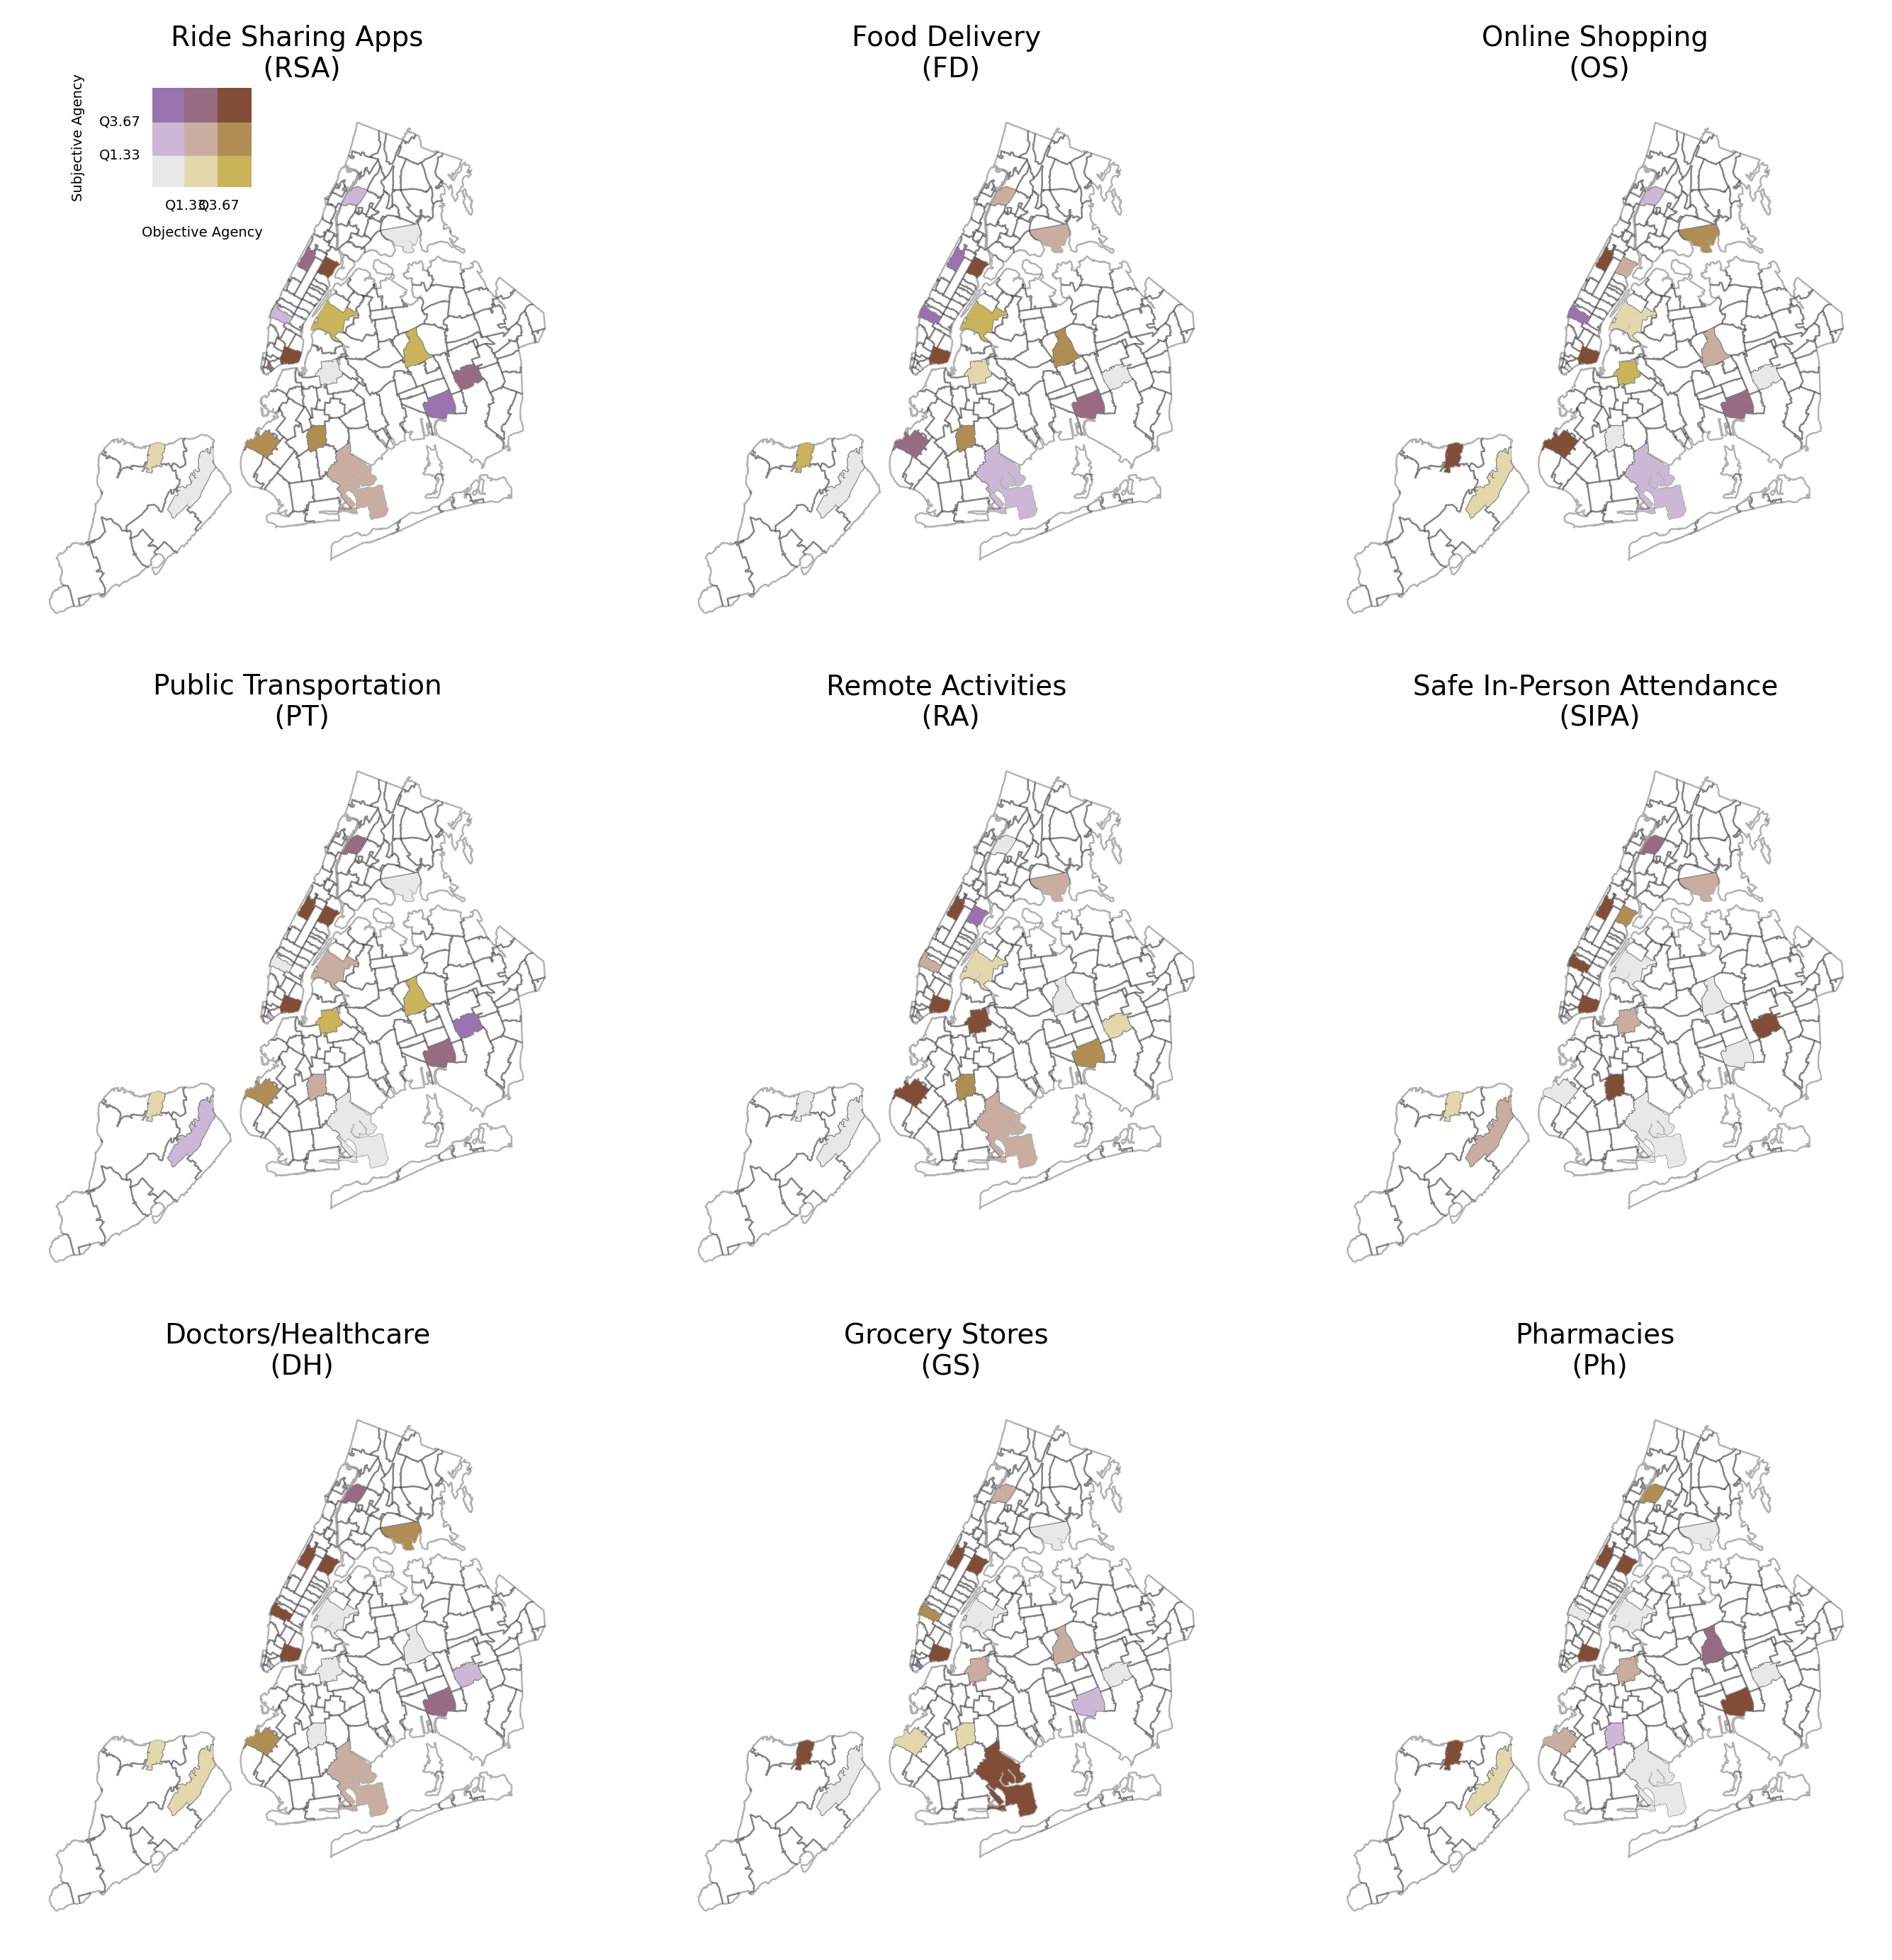

In [38]:
# Create a 3x3 subplot grid
gdf_merged_services = gdf.merge(df_grouped_services, on='MODZCTA', how='right')
fig, axes = plt.subplots(3, 3, figsize=(8, 8), dpi=350)
axes = axes.flatten()  # Flatten to iterate over the axes easily

for i, service in enumerate(services):
    # Define column names for availability and realistic perception
    avail_col = f'agency_{service}_avail'
    realistic_col = f'agency_{service}_realistic'

    # Bin the data using quantiles
    gdf_merged_services[f'{service}_avail_bin'] = pd.qcut(gdf_merged_services[avail_col], num_bins, labels=False)
    gdf_merged_services[f'{service}_realistic_bin'] = pd.qcut(gdf_merged_services[realistic_col], num_bins, labels=False)

    # Create bivariate class
    gdf_merged_services[f'{service}_bivariate_class'] = (
        gdf_merged_services[f'{service}_realistic_bin'] * num_bins + gdf_merged_services[f'{service}_avail_bin']
    )
    gdf_merged_services['plot_color'] = gdf_merged_services[f'{service}_bivariate_class'].apply(lambda x: tuple(colorlist[x]))

    # Select the current axis
    ax = axes[i]

    # Plot the map
    gdf.plot(ax=ax, color='white', alpha=0.3, edgecolor='black', linewidth=0.5)
    gdf_merged_services.plot(color = gdf_merged_services['plot_color'],
        linewidth=0.5,
        edgecolor='none',
        legend=False,
        ax=ax
    )

    # Add title for each service
    # ax.set_title(f"{service.capitalize()} Service", fontsize=14)
    title_text = service_title_dic[service].replace(',', '\n')
    ax.set_title(title_text, fontsize=8)
    ax.axis("off")  # Remove outer frame and axis labels


# Hide any unused subplots
for j in range(len(services), len(axes)):
    axes[j].axis("off")

legend_ax = fig.add_axes([0.1, 0.9, 0.05, 0.05])  # Adjust position and size as needed
legend_ax.set_aspect('equal', adjustable='box')

# Populate the legend with binned colors
for i in range(num_bins):
    for j in range(num_bins):
        legend_ax.add_patch(plt.Rectangle((j, i), 1, 1, color=colorlist[i * num_bins + j]))

legend_ax.set_xlim([0, num_bins])
legend_ax.set_ylim([0, num_bins])

# Configure ticks and labels
legend_ax.set_xticks([1., 2.])
legend_ax.set_yticks([1., 2.])
legend_ax.set_xticklabels(['Q1.33', 'Q3.67'])  # Customize based on your data
legend_ax.set_yticklabels(['Q1.33', 'Q3.67'])

for label in legend_ax.get_xticklabels():
    label.set_fontsize(4)

for label in legend_ax.get_yticklabels():
    label.set_fontsize(4)

legend_ax.set_xlabel("Objective Agency", fontsize=4)
legend_ax.set_ylabel("Subjective Agency", fontsize=4)

# Remove the frame of the legend
legend_ax.spines['top'].set_visible(False)
legend_ax.spines['right'].set_visible(False)
legend_ax.spines['bottom'].set_visible(False)
legend_ax.spines['left'].set_visible(False)
legend_ax.tick_params(axis='both', which='both', length=0)

# Adjust spacing
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(2.2, 2.4), dpi=350)
# Plot the merged GeoDataFrame with 'agency_mode' as the color variable

# Overlay the base GeoDataFrame with grey color and a white border
gdf.plot(ax=ax, color='lightgrey', alpha=0.3, edgecolor='white', linewidth=0.5)
gdf_merged_plot = gdf_merged.plot(
    column='agency_mode', ax=ax, cmap='plasma', edgecolor='none', vmin=4, vmax=22
)
# highlight_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.2)
# Set title and remove axis
ax.set_title('Factor Agency Scores', fontsize=8)
ax.axis('off')

# Create colorbar
cbar_ax = fig.add_axes([0.3, 0.12, 0.5, 0.02])  # Adjust position [left, bottom, width, height]
sm = mpl.cm.ScalarMappable(cmap='plasma', norm=mpl.colors.Normalize(vmin=4, vmax=22))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=6,width=0.5)  # Set colorbar font size
cbar.outline.set_linewidth(0.5)

plt.tight_layout()
# plt.show()
# plt.savefig('../results/scores/agency_origin_map.png', transparent=True,dpi=350,bbox_inches='tight',pad_inches=0.)

In [39]:
df_agency

,agency_pub_trans_avail,agency_pub_trans_realistic,agency_uber_avail,agency_uber_realistic,agency_delivery_avail,agency_delivery_realistic,agency_grocery_avail,agency_grocery_realistic,agency_pharma_avail,agency_pharma_realistic,...,agency_pharma_group,agency_docs_group,agency_online_group,agency_IP_safe_group,agency_remote_group,total_avail,total_realistic,num_items,agency,agency_diff
0,1,-1,1,-2,1,-1,1,1,1,1,...,2.0,2.0,2.0,2.0,4.0,2,9,16,11,7
1,1,1,-1,-1,1,1,1,1,1,1,...,2.0,2.0,1.0,4.0,2.0,3,5,16,8,2
2,1,1,1,1,1,1,1,1,1,1,...,2.0,2.0,2.0,4.0,2.0,7,7,16,14,0
3,-2,1,1,1,1,-1,1,-1,-1,0,...,3.0,1.0,2.0,4.0,4.0,-3,0,14,-3,3
4,1,1,1,-1,1,1,1,1,1,-1,...,1.0,2.0,1.0,4.0,1.0,3,8,16,11,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,1,-2,2,2,2,-1,1,-1,2,2,...,2.0,2.0,1.0,4.0,4.0,3,12,14,15,9
1340,2,0,-2,-2,1,-1,0,-2,-2,1,...,3.0,3.0,3.0,4.0,3.0,-2,-2,16,-4,0
1341,2,2,2,2,2,2,2,2,2,1,...,1.0,2.0,2.0,4.0,4.0,13,14,14,27,1
1342,1,1,2,-1,2,-2,-2,2,2,-2,...,1.0,2.0,2.0,4.0,2.0,2,9,16,11,7
